In [1]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import R2Score
from torch.optim  import  lr_scheduler
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [2]:

# self defined func
from data_process_v2 import norm_mean_std, create_train_test_dataset_selectout, ClimSimDataset
from train_util_new import min_max_clip, test, train, save_submit_nc_sel
from test_util  import test_model_ensemble

batch_size = 2048
submit = True
model_name = 'bagging'

data_source, test_size = 'large', 0.15 # or small for quick test
data_source, test_size = 'test', 0.99 # or small for quick test

# R_crit = 0.65 # threshold to save output 
# T_0 = 10 # CosineAnnealingWarmRestarts
# epochs = 4*T_0 # total epoch NxT_0 N = 1,2,3,4

##########################################################################################################
# output_selection
##########################################################################################################
output_mask = np.ones(368)
output_mask[132:148] = 0 # remove q0002 132-147

##########################################################################################################
# load data
########################################################################################################## 
if submit:
    train_dataset, test_dataset, output_mask, input_offset, input_scale, output_offset, output_scale, submit_input, output_selection, output_name \
    = create_train_test_dataset_selectout(dataset = data_source, norm='std', test_size=test_size, output_selection = output_mask, submit=submit)
    # submit data
    submit_dataloader = DataLoader(submit_input, batch_size=5000, shuffle=False)
else:
    train_dataset, test_dataset, output_mask, input_offset, input_scale, output_offset, output_scale, output_selection, output_name \
    = create_train_test_dataset_selectout(dataset = data_source, norm='std', test_size=test_size, output_selection = output_mask, submit=submit)


output_min = torch.tensor(train_dataset.output.min(axis=0))
output_max = torch.tensor(train_dataset.output.max(axis=0))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)
input_dim = input_offset.size
output_dim = output_offset.size 

root = '/tigress/cw55/work/2024_leap_climsim'
data_name = list(pd.read_csv(f'{root}/data/sample_submission.csv').columns[1:])

Removed fixed input. Now the number of the input feature is  (490,)
Removed fixed input. Now the number of the output feature is (292,)
train sample size: 15137
test sample size: 1498591


# load model

In [3]:
from FNN_baseline_v1_sel import FNN, ln_block
from Unet2d_baseline_v1 import Unet2d, CNN_block
from Transformer import Transformer, MLP, MSA,PatchEmbedding_PosiEmbedding,Trans_Block

In [4]:
# set model path 
R2_ckpt_path = {
    'FNN1':          '../results/FNN_v2_all_outi_0_e40_r2all_0.704_r2sel_0.628',
    'FNN2':          '../results/FNN_v2_all_outi_0_e20_r2all_0.705_r2sel_0.628',  
} 
model_list = { } 
# load saved model
for name in R2_ckpt_path:
    print(name)
    PATH = R2_ckpt_path[name]
    model = torch.load(f'{PATH}.ckpt')
    model.eval()
    model_list[name] = model

FNN1
FNN2


In [5]:
R2value_list = [] 
loss_test = []
loss_fn = nn.MSELoss()
for name in model_list:
    print(name)
    model = model_list[name]
    l_test, R2value = test(test_dataloader, model, loss_fn, output_mask, device, output_selection=output_selection)
    R2value_list.append(R2value) 
    loss_test.append(l_test)

FNN1
Test Error:  Avg loss: 0.37169 R2score_sele: 0.628 
 R2score(R=1 for mask=0): 0.705  
FNN2
Test Error:  Avg loss: 0.37171 R2score_sele: 0.628 
 R2score(R=1 for mask=0): 0.705  


R_ALL: 0.7050683289442373
R_ALL: 0.7050401787071124
R2_max_merge 0.7098726427749448


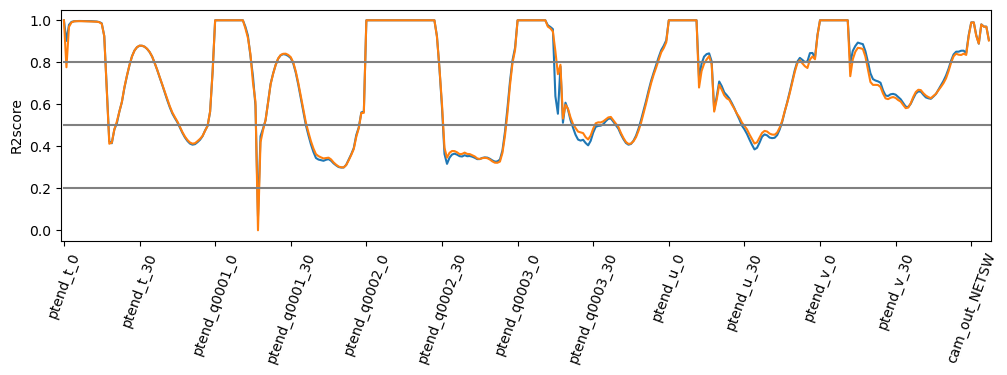

In [6]:
plt.subplots(figsize=(12, 3))
# for R2value in R2_list+[R2_cnn]+[R2_fnn]:
for R2value in R2value_list:
    plt.plot(R2value) 
    print(f'R_ALL: {R2value.mean()}')
plt.plot([0,368],[0.8,0.8],c='grey')
plt.plot([0,368],[0.5,0.5],c='grey')
plt.plot([0,368],[0.2,0.2],c='grey')
# plt.ylim(0,1.01)
plt.xlim(-1,368)
plt.ylabel('R2score')
plt.xticks(np.arange(len(data_name))[::30],data_name[::30],rotation=70) 
R2_merge = np.array(R2value_list).max(axis=0) # select the max R2 to merge
print('R2_max_merge',np.mean(R2_merge))
plt.show()

# modele mean

In [7]:
l_test, R2value = test_model_ensemble(test_dataloader, model_list, loss_fn, output_mask, device, output_selection=output_selection)

100%|██████████| 732/732 [00:21<00:00, 33.29it/s]

Test Error:  Avg loss: 0.36265 R2score_sele: 0.637 
 R2score(R=1 for mask=0): 0.712  
